In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings("ignore")

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
import lightgbm as lgbm
from sklearn.model_selection import KFold

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

PassengerId = test["PassengerId"]
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [5]:
full_data = [train, test]

for df in full_data:
    df["Name_length"] = df["Name"].apply(len)
    df["Has_Cabin"] = df["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
    df["FamilySize"] = df["SibSp"] + df["Parch"] + 1
    df["Alone"] = 0
    df.loc[df["FamilySize"] == 1, "Alone"] = 1
    df["Embarked"] = df["Embarked"].fillna("S")
    df["Fare"] = df["Fare"].fillna(train["Fare"].median())
    age_avg = df["Age"].mean()
    age_std = df["Age"].std()
    age_null_count = df["Age"].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    df["Age"][np.isnan(df["Age"])] = age_null_random_list
    df["Age"] = df["Age"].astype(int)
train["CategoricalFare"] = pd.qcut(train["Fare"], 4)
train["CategoricalAge"] = pd.cut(train["Age"], 5)

In [6]:
def get_title(name):
    title_search = re.search("([A-Za-z]+)\.", name)
    if title_search:
        return title_search.group(1)
    return "　"

In [7]:
for df in full_data:
    df["Title"] = df["Name"].apply(get_title)
    df["Title"] = df["Title"].replace(["Lady", "Countess", "Capt", "Col", "Don", "Dr", "Major", "Rev", "Sir", "Jonkheer", "Dona"], "Rare")
    df["Title"] = df["Title"].replace("Mlle", "Miss")
    df["Title"] = df["Title"].replace("Ms", "Miss")
    df["Title"] = df["Title"].replace("Mme", "Mrs")
    df["Sex"] = df["Sex"].map({"female": 0, "male": 1}).astype(int)
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    df["Title"] = df["Title"].map(title_mapping)
    df["Title"] = df["Title"].fillna(0)
    df["Embarked"] = df["Embarked"].map({"S": 0, "C": 1, "Q": 2}).astype(int)
    df.loc[df["Fare"] <= 7.91, "Fare"] = 0
    df.loc[(df["Fare"] > 7.91) & (df["Fare"] <= 14.454), "Fare"] = 1
    df.loc[(df["Fare"] > 14.454) & (df["Fare"] <= 31), "Fare"] = 2
    df.loc[df["Fare"] > 31, "Fare"] = 3
    df["Fare"] = df["Fare"].astype(int)
    df.loc[df["Age"] <= 16, "Age"] = 0
    df.loc[(df["Age"] > 16) & (df["Age"] <= 32), "Age"] = 1
    df.loc[(df["Age"] > 32) & (df["Age"] <= 48), "Age"] = 2
    df.loc[(df["Age"] > 48) & (df["Age"] <= 64), "Age"] = 3
    df.loc[df["Age"] > 64, "Age"] = 4

In [8]:
drop_elements = ["PassengerId", "Name", "Ticket", "Cabin", "SibSp"]
train = train.drop(drop_elements, axis=1)
train = train.drop(["CategoricalAge", "CategoricalFare"], axis=1)
test = test.drop(drop_elements, axis=1)

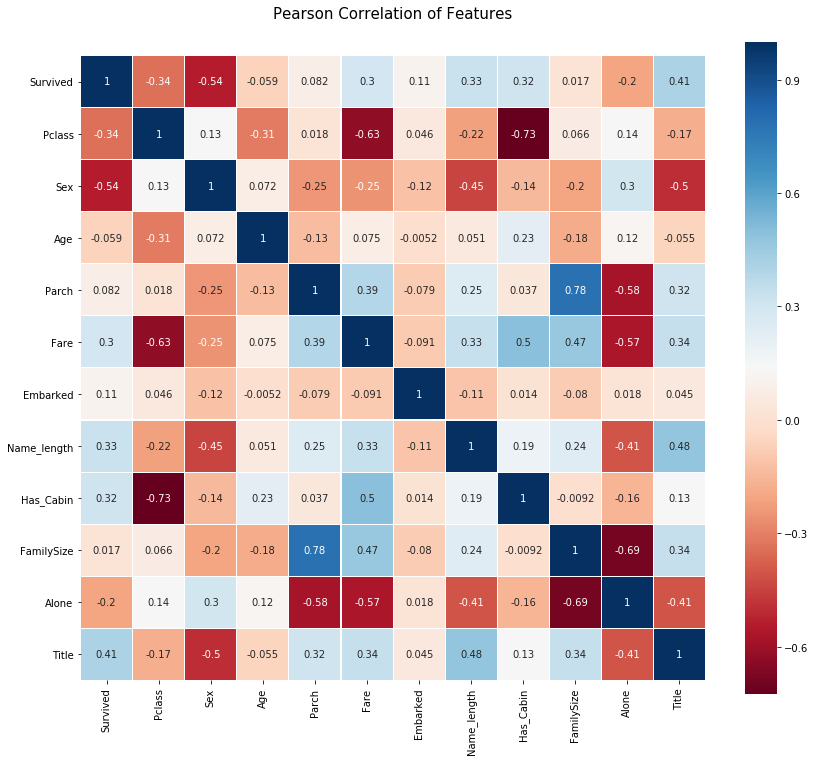

In [9]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14, 12))
plt.title("Pearson Correlation of Features", y=1.05, size=15)
sns.heatmap(train.astype(float).corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor="white", annot=True)

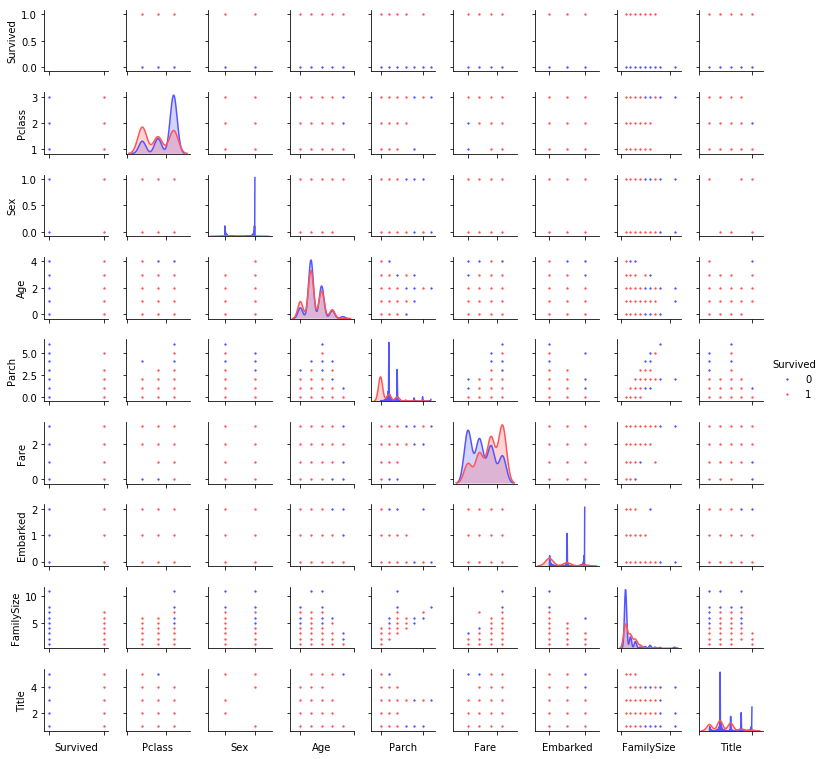

In [10]:
g = sns.pairplot(train[[u"Survived", u"Pclass", u"Sex", u"Age", u"Parch", u"Fare", u"Embarked", u"FamilySize", u"Title"]], hue="Survived", palette="seismic", size=1.2, diag_kind="kde", diag_kws=dict(shade=True), plot_kws=dict(s=10))
g.set(xticklabels=[])

In [11]:
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0
NFOLDS = 5
kf = KFold(n_splits=NFOLDS, random_state=SEED)

In [14]:
y_train = train["Survived"].ravel()
train = train.drop(["Survived"], axis=1)
x_train = train.values
x_test = test.values

In [15]:
X_par, X_par_test, y_par, y_par_test = train_test_split(x_train, y_train, test_size=0.2, random_state=0)

train_data = lgbm.Dataset(data=X_par, label=y_par, free_raw_data=False)
test_data = lgbm.Dataset(data=X_par_test, label=y_par_test, free_raw_data=False)

final_train_set = lgbm.Dataset(data=x_train, label=y_train, free_raw_data=False)

In [16]:
lgbm_params = {
    "boosting_type": "gbdt",
    "application": "binary",
    "learning_rate": 0.15,
    "min_data_in_leaf": 20,
    "num_leaves": 41,
    "metric": "binary_logloss",
    "drop_rate": 0.1
}

In [17]:
evaluation_results = {}
clf = lgbm.train(
    train_set=train_data,
    params=lgbm_params,
    valid_sets=[train_data, test_data],
    valid_names=["Train", "Test"],
    evals_result=evaluation_results,
    num_boost_round=500,
    early_stopping_rounds=100,
    verbose_eval=20)
optimum_boost_rounds = clf.best_iteration

Training until validation scores don't improve for 100 rounds.
[20]	Train's binary_logloss: 0.323527	Test's binary_logloss: 0.414591
[40]	Train's binary_logloss: 0.2535	Test's binary_logloss: 0.435347
[60]	Train's binary_logloss: 0.214612	Test's binary_logloss: 0.46082
[80]	Train's binary_logloss: 0.188251	Test's binary_logloss: 0.475501
[100]	Train's binary_logloss: 0.169584	Test's binary_logloss: 0.490441
[120]	Train's binary_logloss: 0.153804	Test's binary_logloss: 0.516513
Early stopping, best iteration is:
[20]	Train's binary_logloss: 0.323527	Test's binary_logloss: 0.414591


In [107]:
clf_final = lgbm.train(
    train_set=final_train_set,
    params=lgbm_params,
    num_boost_round=optimum_boost_rounds,
    verbose_eval=0)

y_pred = np.round(clf_final.predict(x_test)).astype(int)

In [108]:
StackingSubmission = pd.DataFrame(
    {"PassengerId": PassengerId,
     "Survived": y_pred})
StackingSubmission.to_csv("StackingSubmission.csv", index=False)